# Klasifikasi Gambar Rempah-Rempah Indonesia

- Nama : Fiyanda Ma'muri
- Deskripsi : Membuat model untuk klasifikasi gambar dengan arsitektur MobileNetv2 + Feature Extraction untuk web klasifikasi rempah sebagai proyek skripsi.

## import library

In [12]:
import os
import pandas as pd
import numpy as np
import shutil
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
import json

## import datasets

In [2]:
image_data = 'datasets'

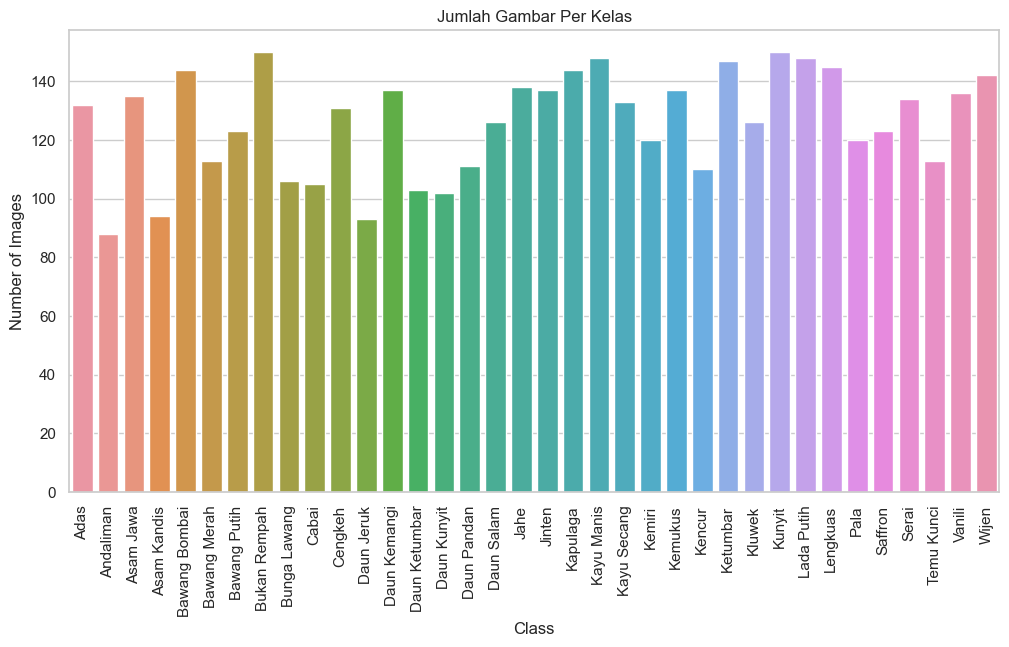

In [3]:
# Menghitung jumlah gambar di setiap kelas (folder)
class_counts = []
class_names = []

for class_name in os.listdir(image_data):
    class_path = os.path.join(image_data, class_name)
    if os.path.isdir(class_path): 
        num_images = len(os.listdir(class_path))
        class_counts.append(num_images)
        class_names.append(class_name)

df = pd.DataFrame({'Class': class_names, 'Count': class_counts})

# Visualisasi dengan seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Count", data=df)
plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Jumlah Gambar Per Kelas")
plt.show()

In [4]:
df

,Class,Count
0,Adas,132
1,Andaliman,88
2,Asam Jawa,135
3,Asam Kandis,94
4,Bawang Bombai,144
5,Bawang Merah,113
6,Bawang Putih,123
7,Bukan Rempah,150
8,Bunga Lawang,106
9,Cabai,105


## split datasets

In [5]:
def split_dataset(source_dir, train_dir, val_dir, test_dir, train_ratio=0.8, val_ratio=0.10):
    """
    Membagi dataset ke dalam folder Train, Validation, dan Test menggunakan train_test_split dari sklearn.

    Parameters:
    source_dir (str): Path dataset asli.
    train_dir (str): Path untuk dataset training.
    val_dir (str): Path untuk dataset validation.
    test_dir (str): Path untuk dataset testing.
    train_ratio (float): Proporsi data untuk training.
    val_ratio (float): Proporsi data untuk validation.
    """
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    test_ratio = 1.0 - (train_ratio + val_ratio)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        images = [img for img in images if os.path.isfile(os.path.join(class_path, img))]

        # Split train dan sisa
        train_images, temp_images = train_test_split(
            images, test_size=(1 - train_ratio), random_state=42, shuffle=True
        )

        # Split sisa menjadi val dan test
        val_relative_ratio = val_ratio / (val_ratio + test_ratio)
        val_images, test_images = train_test_split(
            temp_images, test_size=(1 - val_relative_ratio), random_state=42, shuffle=True
        )

        for dataset_dir, dataset_images in zip([train_dir, val_dir, test_dir],
                                               [train_images, val_images, test_images]):
            class_dest = os.path.join(dataset_dir, class_name)
            os.makedirs(class_dest, exist_ok=True)

            for img in dataset_images:
                shutil.copy(os.path.join(class_path, img), os.path.join(class_dest, img))

# Path dataset asli dan tujuan
source_dataset = "datasets"
train_dataset = "split-dataset/Train"
val_dataset = "split-dataset/Validation"
test_dataset = "split-dataset/Test"

# Jalankan fungsi split
split_dataset(source_dataset, train_dataset, val_dataset, test_dataset)

## preprocessing data

In [6]:
# Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data dari folder yang telah dibagi
train_generator = train_datagen.flow_from_directory(
    train_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 3621 images belonging to 36 classes.
Found 452 images belonging to 36 classes.
Found 471 images belonging to 36 classes.


## modelling

In [7]:
# Memuat model MobileNetV2 tanpa fully connected layers (include_top=False)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Membekukan semua lapisan MobileNetV2 agar tidak dilatih ulang
base_model.trainable = False

# Membuat model baru dengan lapisan tambahan (feature extraction)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(36, activation='softmax')
])


# Menyusun model dengan optimizer, loss function, dan metrik evaluasi
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Menampilkan ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 36)             │         2,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,432,548 (9.28 MB)

 Trainable params: 174,564 (681.89 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Custom Callback untuk menghentikan training jika akurasi mencapai 92%
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc=0.90):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_acc:
            print(f"\nTraining dihentikan karena akurasi telah mencapai {logs.get('accuracy'):.2f}")
            self.model.stop_training = True

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
stop_at_acc = StopAtAccuracy(target_acc=0.92)

In [9]:
# Melakukan training
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), StopAtAccuracy()]
)

c:\Users\fiyan\Documents\REMPAH CLASIFICATION\imgvenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 208s 887ms/step - accuracy: 0.1281 - loss: 3.3066 - precision: 0.4249 - recall: 0.0030 - val_accuracy: 0.5951 - val_loss: 1.9095 - val_precision: 0.9600 - val_recall: 0.0531
Epoch 2/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 165s 729ms/step - accuracy: 0.4286 - loss: 2.0479 - precision: 0.7882 - recall: 0.1313 - val_accuracy: 0.7655 - val_loss: 1.0643 - val_precision: 0.9396 - val_recall: 0.3783
Epoch 3/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 166s 730ms/step - accuracy: 0.5781 - loss: 1.4303 - precision: 0.8125 - recall: 0.3353 - val_accuracy: 0.8075 - val_loss: 0.7657 - val_precision: 0.9676 - val_recall: 0.5951
Epoch 4/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 181s 796ms/step - accuracy: 0.6567 - loss: 1.1568 - precision: 0.8190 - recall: 0.4608 - val_accuracy: 0.8429 - val_loss: 0.6189 - val_precision: 0.9469 - val_recall: 0.6704
Epoch 5/25
227/227 ━━━━━━━━━━━━━━━━━━━━ 153s 673ms/step - accuracy: 0.7277 - loss: 0.9285 - precision: 0.8636 - recall: 0.5737 - val_accuracy: 0

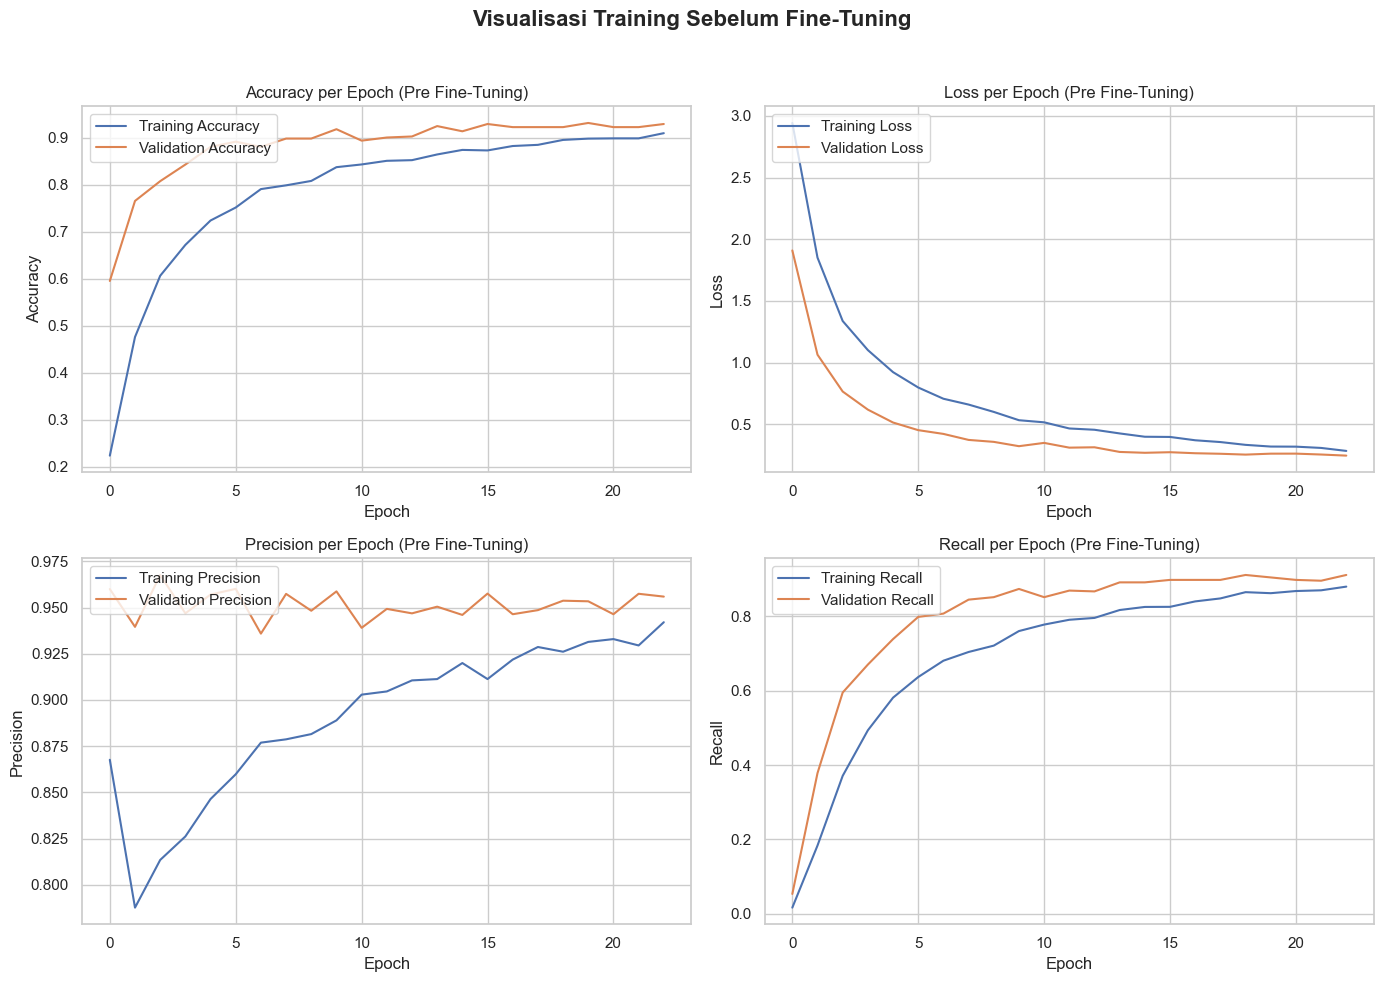

In [10]:
plt.figure(figsize=(14, 10))
plt.suptitle('Visualisasi Training Sebelum Fine-Tuning', fontsize=16, fontweight='bold')

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch (Pre Fine-Tuning)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch (Pre Fine-Tuning)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision per Epoch (Pre Fine-Tuning)')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall per Epoch (Pre Fine-Tuning)')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Supaya judul besar tidak menutupi subplot
plt.show()

In [ ]:
## fine tunning
base_model.trainable = True

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [14]:
# Callback ulang
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
stop_at_acc = StopAtAccuracy(target_acc=0.95)

In [15]:
# 8. Lanjutkan training fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping, stop_at_acc, model_checkpoint]
)

Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.5407 - loss: 1.7992 - precision_1: 0.6227 - recall_1: 0.4611

227/227 ━━━━━━━━━━━━━━━━━━━━ 240s 990ms/step - accuracy: 0.5411 - loss: 1.7973 - precision_1: 0.6231 - recall_1: 0.4614 - val_accuracy: 0.9292 - val_loss: 0.2677 - val_precision_1: 0.9448 - val_recall_1: 0.9093
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 224s 986ms/step - accuracy: 0.7500 - loss: 0.7920 - precision_1: 0.8466 - recall_1: 0.6665 - val_accuracy: 0.9314 - val_loss: 0.2677 - val_precision_1: 0.9359 - val_recall_1: 0.9049
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.8166 - loss: 0.6618 - precision_1: 0.8957 - recall_1: 0.7303 - val_accuracy: 0.9115 - val_loss: 0.2743 - val_precision_1: 0.9226 - val_recall_1: 0.8960
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.7926 - loss: 0.6479 - precision_1: 0.8769 - recall_1: 0.7223 - val_accuracy: 0.9115 - val_loss: 0.2804 - val_precision_1: 0.9199 - val_recall_1: 0.8894
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.8176 - loss: 0.5903 - precision_1: 0.8667 - recall_1: 0.7437

227/227 ━━━━━━━━━━━━━━━━━━━━ 183s 807ms/step - accuracy: 0.8177 - loss: 0.5902 - precision_1: 0.8667 - recall_1: 0.7437 - val_accuracy: 0.9137 - val_loss: 0.2617 - val_precision_1: 0.9250 - val_recall_1: 0.9004
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.8211 - loss: 0.5456 - precision_1: 0.8855 - recall_1: 0.7616

227/227 ━━━━━━━━━━━━━━━━━━━━ 201s 886ms/step - accuracy: 0.8211 - loss: 0.5455 - precision_1: 0.8855 - recall_1: 0.7616 - val_accuracy: 0.9159 - val_loss: 0.2574 - val_precision_1: 0.9317 - val_recall_1: 0.9049
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 208s 915ms/step - accuracy: 0.8427 - loss: 0.4995 - precision_1: 0.8914 - recall_1: 0.7827 - val_accuracy: 0.9137 - val_loss: 0.2650 - val_precision_1: 0.9269 - val_recall_1: 0.8982
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.8568 - loss: 0.4671 - precision_1: 0.9029 - recall_1: 0.8071

227/227 ━━━━━━━━━━━━━━━━━━━━ 187s 825ms/step - accuracy: 0.8568 - loss: 0.4671 - precision_1: 0.9029 - recall_1: 0.8071 - val_accuracy: 0.9181 - val_loss: 0.2517 - val_precision_1: 0.9276 - val_recall_1: 0.9071
Epoch 9/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - accuracy: 0.8600 - loss: 0.4515 - precision_1: 0.9086 - recall_1: 0.8115

227/227 ━━━━━━━━━━━━━━━━━━━━ 208s 916ms/step - accuracy: 0.8599 - loss: 0.4515 - precision_1: 0.9086 - recall_1: 0.8115 - val_accuracy: 0.9226 - val_loss: 0.2381 - val_precision_1: 0.9341 - val_recall_1: 0.9093
Epoch 10/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.8609 - loss: 0.4521 - precision_1: 0.9065 - recall_1: 0.8235

227/227 ━━━━━━━━━━━━━━━━━━━━ 196s 863ms/step - accuracy: 0.8609 - loss: 0.4520 - precision_1: 0.9065 - recall_1: 0.8235 - val_accuracy: 0.9226 - val_loss: 0.2229 - val_precision_1: 0.9344 - val_recall_1: 0.9137
Epoch 11/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.8678 - loss: 0.4224 - precision_1: 0.9090 - recall_1: 0.8138

227/227 ━━━━━━━━━━━━━━━━━━━━ 180s 793ms/step - accuracy: 0.8678 - loss: 0.4224 - precision_1: 0.9090 - recall_1: 0.8138 - val_accuracy: 0.9181 - val_loss: 0.2229 - val_precision_1: 0.9299 - val_recall_1: 0.9093
Epoch 12/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 185s 816ms/step - accuracy: 0.8713 - loss: 0.4018 - precision_1: 0.9101 - recall_1: 0.8250 - val_accuracy: 0.9159 - val_loss: 0.2249 - val_precision_1: 0.9341 - val_recall_1: 0.9093
Epoch 13/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 199s 875ms/step - accuracy: 0.8870 - loss: 0.3838 - precision_1: 0.9219 - recall_1: 0.8458 - val_accuracy: 0.9181 - val_loss: 0.2248 - val_precision_1: 0.9342 - val_recall_1: 0.9115
Epoch 14/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.8774 - loss: 0.3748 - precision_1: 0.9164 - recall_1: 0.8417

227/227 ━━━━━━━━━━━━━━━━━━━━ 198s 872ms/step - accuracy: 0.8774 - loss: 0.3748 - precision_1: 0.9164 - recall_1: 0.8418 - val_accuracy: 0.9159 - val_loss: 0.2193 - val_precision_1: 0.9278 - val_recall_1: 0.9093
Epoch 15/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.8938 - loss: 0.3459 - precision_1: 0.9300 - recall_1: 0.8566

227/227 ━━━━━━━━━━━━━━━━━━━━ 204s 899ms/step - accuracy: 0.8938 - loss: 0.3460 - precision_1: 0.9299 - recall_1: 0.8566 - val_accuracy: 0.9248 - val_loss: 0.2139 - val_precision_1: 0.9345 - val_recall_1: 0.9159
Epoch 16/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 204s 897ms/step - accuracy: 0.9004 - loss: 0.3188 - precision_1: 0.9319 - recall_1: 0.8685 - val_accuracy: 0.9204 - val_loss: 0.2195 - val_precision_1: 0.9279 - val_recall_1: 0.9115
Epoch 17/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 194s 854ms/step - accuracy: 0.9022 - loss: 0.3197 - precision_1: 0.9322 - recall_1: 0.8602 - val_accuracy: 0.9159 - val_loss: 0.2284 - val_precision_1: 0.9257 - val_recall_1: 0.9093
Epoch 18/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 219s 965ms/step - accuracy: 0.9052 - loss: 0.3014 - precision_1: 0.9282 - recall_1: 0.8778 - val_accuracy: 0.9292 - val_loss: 0.2149 - val_precision_1: 0.9429 - val_recall_1: 0.9137
Epoch 19/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 217s 956ms/step - accuracy: 0.9120 - loss: 0.2882 - precision_1: 0.9385 - recal

227/227 ━━━━━━━━━━━━━━━━━━━━ 215s 946ms/step - accuracy: 0.9153 - loss: 0.2671 - precision_1: 0.9384 - recall_1: 0.8971 - val_accuracy: 0.9248 - val_loss: 0.2101 - val_precision_1: 0.9409 - val_recall_1: 0.9159
Epoch 21/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 216s 948ms/step - accuracy: 0.9184 - loss: 0.2658 - precision_1: 0.9391 - recall_1: 0.8895 - val_accuracy: 0.9270 - val_loss: 0.2192 - val_precision_1: 0.9365 - val_recall_1: 0.9137
Epoch 22/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 205s 903ms/step - accuracy: 0.9059 - loss: 0.2857 - precision_1: 0.9363 - recall_1: 0.8786 - val_accuracy: 0.9270 - val_loss: 0.2128 - val_precision_1: 0.9409 - val_recall_1: 0.9159
Epoch 23/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9034 - loss: 0.2937 - precision_1: 0.9300 - recall_1: 0.8724

227/227 ━━━━━━━━━━━━━━━━━━━━ 212s 933ms/step - accuracy: 0.9034 - loss: 0.2936 - precision_1: 0.9300 - recall_1: 0.8725 - val_accuracy: 0.9248 - val_loss: 0.2073 - val_precision_1: 0.9410 - val_recall_1: 0.9181
Epoch 24/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9229 - loss: 0.2516 - precision_1: 0.9503 - recall_1: 0.8911 - val_accuracy: 0.9314 - val_loss: 0.2123 - val_precision_1: 0.9432 - val_recall_1: 0.9181
Epoch 25/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.9192 - loss: 0.2413 - precision_1: 0.9452 - recall_1: 0.9000

227/227 ━━━━━━━━━━━━━━━━━━━━ 206s 907ms/step - accuracy: 0.9192 - loss: 0.2413 - precision_1: 0.9452 - recall_1: 0.9000 - val_accuracy: 0.9314 - val_loss: 0.1987 - val_precision_1: 0.9437 - val_recall_1: 0.9270
Epoch 26/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 195s 860ms/step - accuracy: 0.9244 - loss: 0.2543 - precision_1: 0.9445 - recall_1: 0.8974 - val_accuracy: 0.9292 - val_loss: 0.2032 - val_precision_1: 0.9434 - val_recall_1: 0.9226
Epoch 27/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9267 - loss: 0.2391 - precision_1: 0.9440 - recall_1: 0.9087 - val_accuracy: 0.9292 - val_loss: 0.2181 - val_precision_1: 0.9412 - val_recall_1: 0.9204
Epoch 28/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 193s 846ms/step - accuracy: 0.9340 - loss: 0.2317 - precision_1: 0.9501 - recall_1: 0.9134 - val_accuracy: 0.9358 - val_loss: 0.2088 - val_precision_1: 0.9455 - val_recall_1: 0.9204
Epoch 29/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 173s 762ms/step - accuracy: 0.9277 - loss: 0.2466 - precision_1: 0.9483 - recall_1

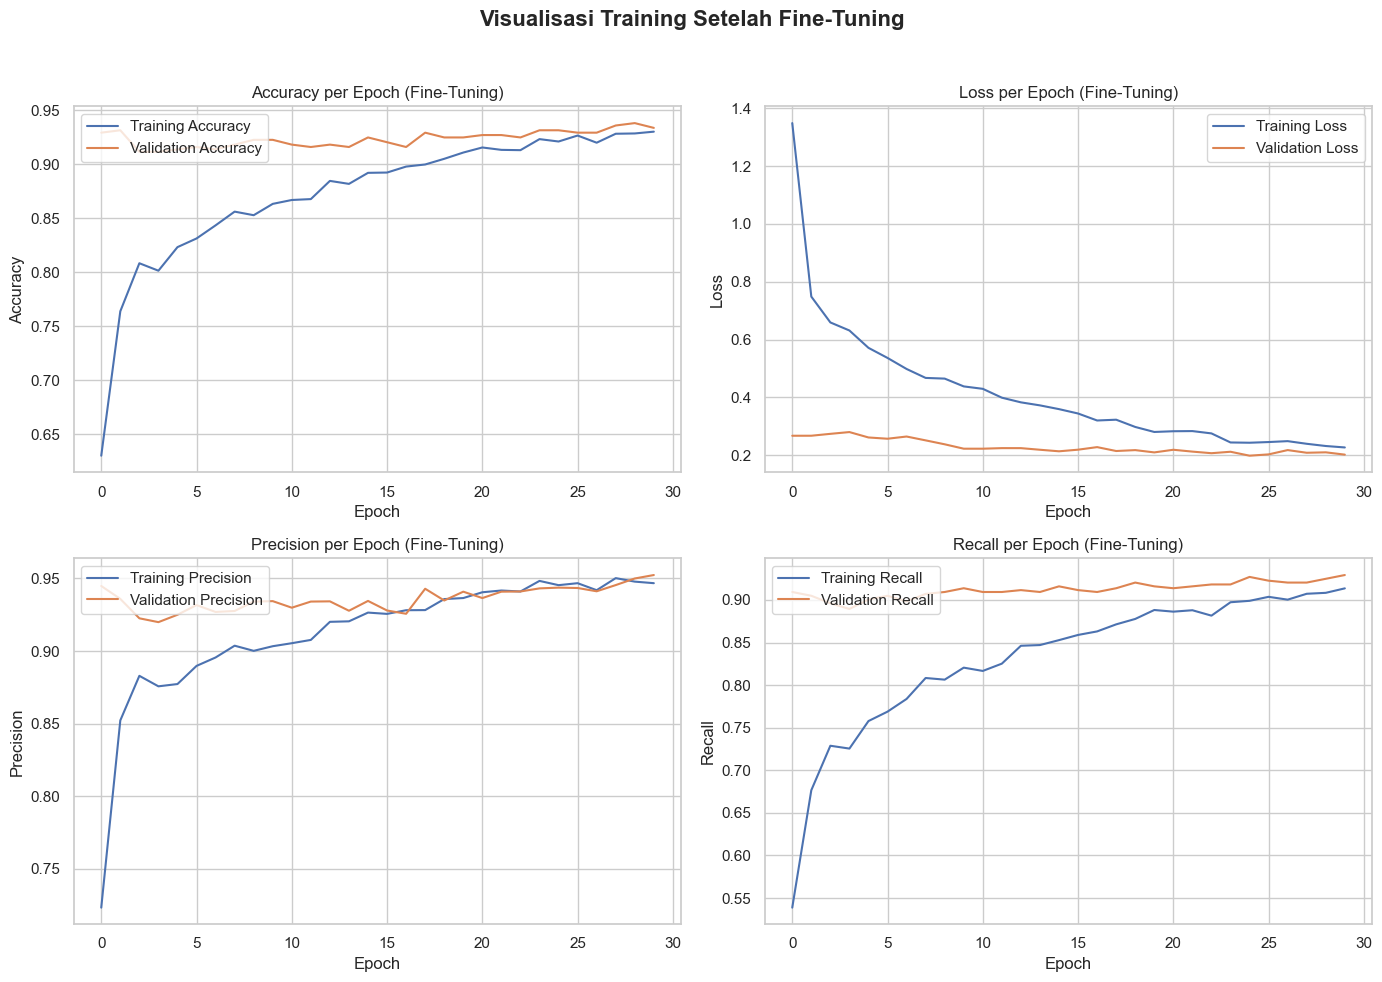

In [16]:
plt.figure(figsize=(14, 10))
plt.suptitle('Visualisasi Training Setelah Fine-Tuning', fontsize=16, fontweight='bold')

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(2, 2, 2)
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Precision
plt.subplot(2, 2, 3)
plt.plot(history_finetune.history['precision_1'], label='Training Precision')
plt.plot(history_finetune.history['val_precision_1'], label='Validation Precision')
plt.title('Precision per Epoch (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='upper left')

# Recall
plt.subplot(2, 2, 4)
plt.plot(history_finetune.history['recall_1'], label='Training Recall')
plt.plot(history_finetune.history['val_recall_1'], label='Validation Recall')
plt.title('Recall per Epoch (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Untuk memberi ruang pada judul besar
plt.show()


## model evaluation

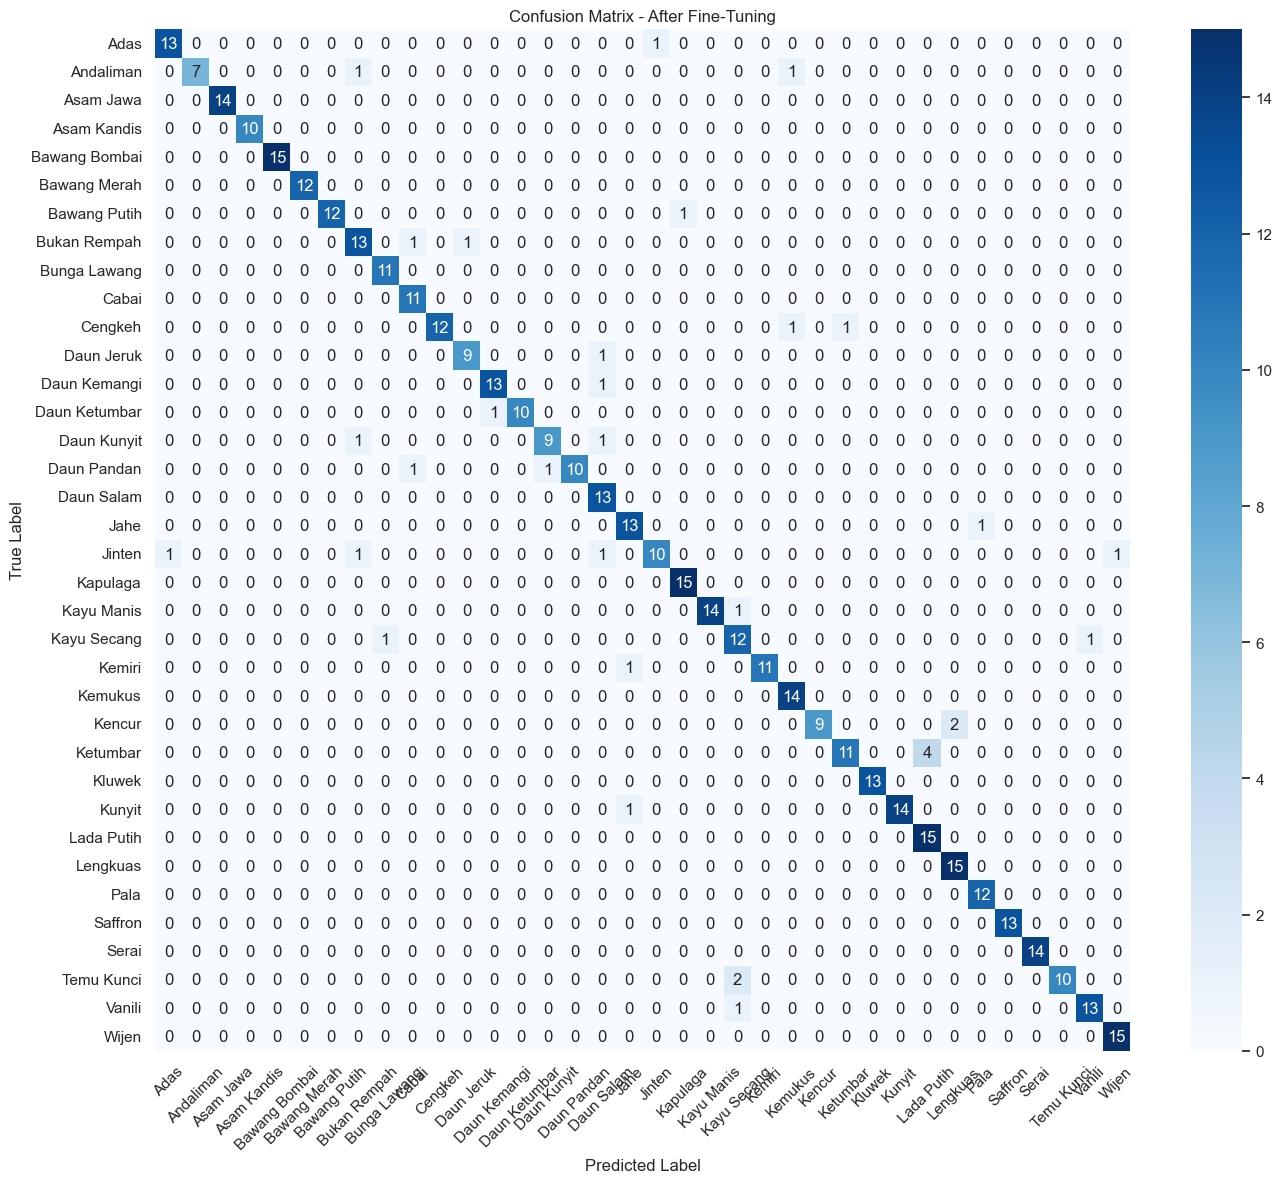


Classification Report (Testing Data):
               precision    recall  f1-score   support

         Adas       0.93      0.93      0.93        14
    Andaliman       1.00      0.78      0.88         9
    Asam Jawa       1.00      1.00      1.00        14
  Asam Kandis       1.00      1.00      1.00        10
Bawang Bombai       1.00      1.00      1.00        15
 Bawang Merah       1.00      1.00      1.00        12
 Bawang Putih       1.00      0.92      0.96        13
 Bukan Rempah       0.81      0.87      0.84        15
 Bunga Lawang       0.92      1.00      0.96        11
        Cabai       0.85      1.00      0.92        11
      Cengkeh       1.00      0.86      0.92        14
   Daun Jeruk       0.90      0.90      0.90        10
 Daun Kemangi       0.93      0.93      0.93        14
Daun Ketumbar       1.00      0.91      0.95        11
  Daun Kunyit       0.90      0.82      0.86        11
  Daun Pandan       1.00      0.83      0.91        12
   Daun Salam       0.76 

In [17]:
# Ambil label kelas (urutannya harus sama)
class_labels = list(train_generator.class_indices.keys())

# Inisialisasi
y_true = []
y_pred = []

# Loop seluruh batch dari test_generator
for images, labels in test_generator:
    predictions = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))
    
    if len(y_true) >= test_generator.samples:
        break

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - After Fine-Tuning')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report (Testing Data):")
print(classification_report(y_true, y_pred, target_names=class_labels))

## Pre-Deployment

In [18]:
# Simpan model dalam format TensorFlow (.h5)
model.save('dashboard/best_model.h5')

In [19]:
# Simpan class_indices ke file JSON
with open("dashboard/labels.json", "w") as f:
    json.dump(train_generator.class_indices, f)

print("Labels berhasil disimpan!")

Labels berhasil disimpan!
